# Segmenting lung images

Here is the starting point for processing CT lung segmentation data from [TOMCAT (PSI)](https://www.psi.ch/en/sls/tomcat)

In [54]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from skimage.io import imread
import matplotlib.pyplot as plt

## Load and Preview Images

In [55]:
lung_image = np.load('04-files/lung_phase.npy')*-1+1 # We invert the image and set it into the range (0,1)
lung_mask = np.load('04-files/lung_mask.npy')

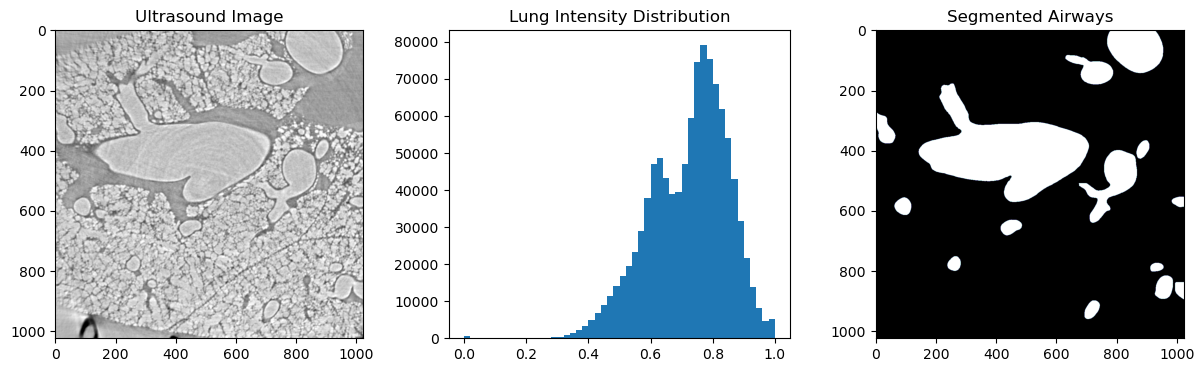

In [56]:
%matplotlib inline

fig, (ax1, ax2 ,ax3) = plt.subplots(1,3, figsize = (15,4))
ax1.imshow(lung_image, cmap='gray')
ax1.set_title('Ultrasound Image')
ax2.hist(lung_image.ravel(),bins=50)
ax2.set_title('Lung Intensity Distribution')
ax3.imshow(lung_mask, cmap = 'bone')
ax3.set_title('Segmented Airways');

## Just focus on the airways
Show the segmentation of the airways and the intensity inside that regions

Text(0.5, 1.0, 'CT Intensity Distribution')

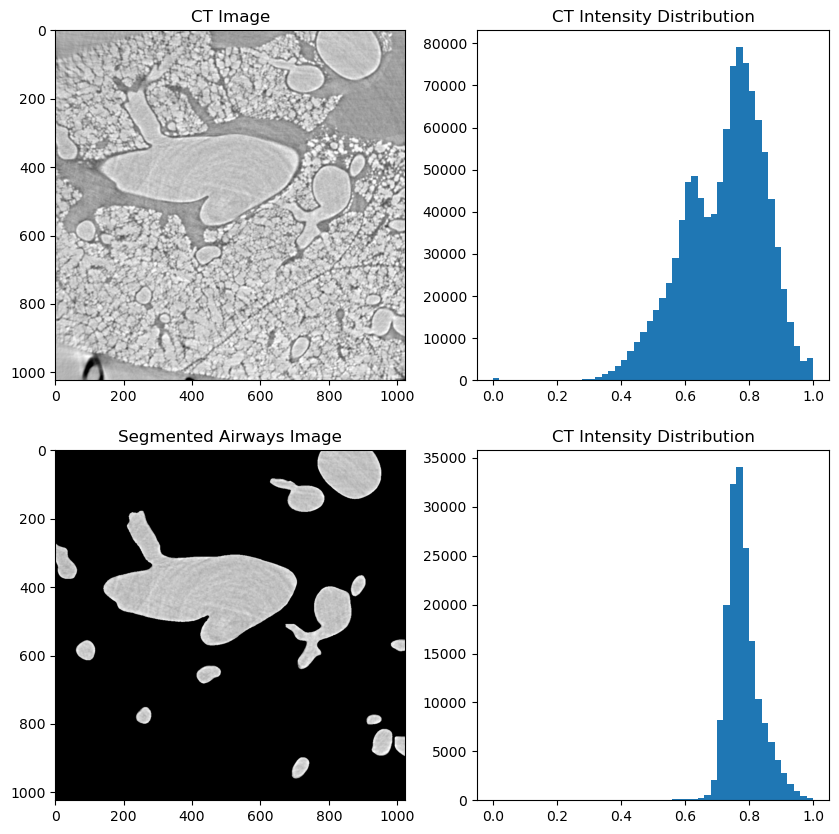

In [57]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10,10))
ax1.imshow(lung_image, cmap='gray')
ax1.set_title('CT Image')
counts, bins, _ = ax2.hist(lung_image.ravel(),bins=50)
ax2.set_title('CT Intensity Distribution')
ax3.imshow(lung_image*lung_mask, cmap='gray')
ax3.set_title('Segmented Airways Image')
ax4.hist(lung_image[lung_mask], bins = bins) # use the same bins again
ax4.set_title('CT Intensity Distribution')

# Simple Segmentation
We see too peaks in this histogram, lets try segmenting between them

Text(0.5, 1.0, 'Segmented airways')

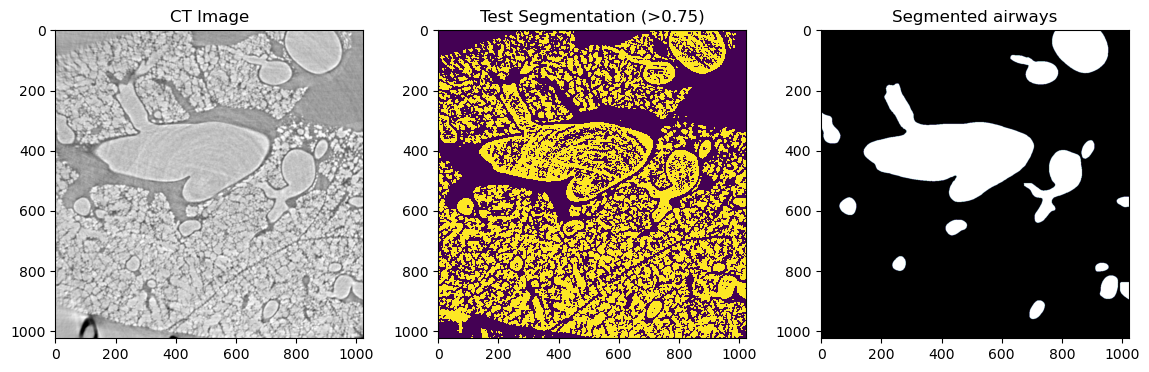

In [58]:
threshold = 0.75
thresholded = lung_image > threshold
%matplotlib inline
fig, (ax1, ax2 ,ax3) = plt.subplots(1,3, figsize = (14,4))
ax1.imshow(lung_image, cmap='gray')
ax1.set_title('CT Image')
ax2.imshow(thresholded, interpolation='none')
ax2.set_title(f'Test Segmentation (>{threshold})')
ax3.imshow(lung_mask, cmap = 'bone')
ax3.set_title('Segmented airways')

# Scoring the Result
We can use the ROC curve to score the result and see how accurately we classified the images. Here the ROC curve is obtained using [SciKit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html).

In [59]:
from sklearn.metrics import roc_curve, auc # roc curve tools

ground_truth_labels = lung_mask.ravel() # we want to make them into vectors
score_value         = lung_image.ravel() # we want to make them into vectors. 

fpr, tpr, _ = roc_curve(ground_truth_labels,score_value)
roc_auc     = auc(fpr,tpr)

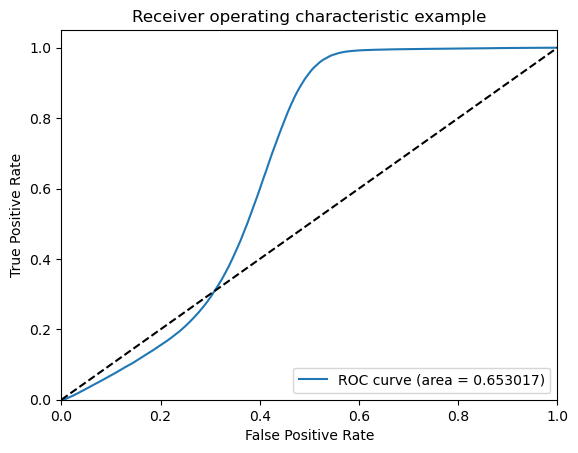

In [60]:
# Visualization
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = {0:02f})'.format(roc_auc))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right");

# Gaussian Filter
Here we apply a gaussian filter and see how the performance changes

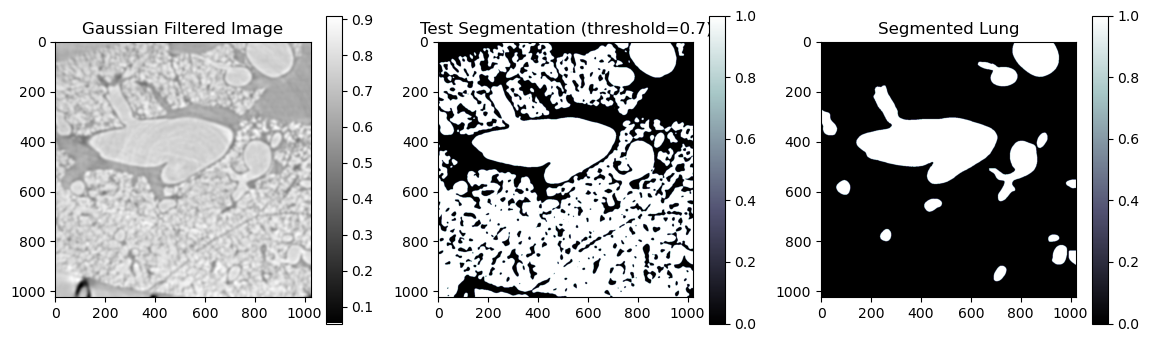

In [61]:
%matplotlib inline
from skimage.filters import gaussian
gus_image = gaussian(lung_image,sigma = 5)

threshold = 0.70
thresholded = gus_image>threshold
# Visualization
fig, (ax1, ax2 ,ax3) = plt.subplots(1,3, figsize = (14,4))
im1 = ax1.imshow(gus_image, cmap='gray')
ax1.set_title('Gaussian Filtered Image')
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(thresholded, cmap = 'bone')
ax2.set_title(f'Test Segmentation ({threshold=})')
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(lung_mask, cmap = 'bone')
ax3.set_title('Segmented Lung')
fig.colorbar(im3, ax=ax3)


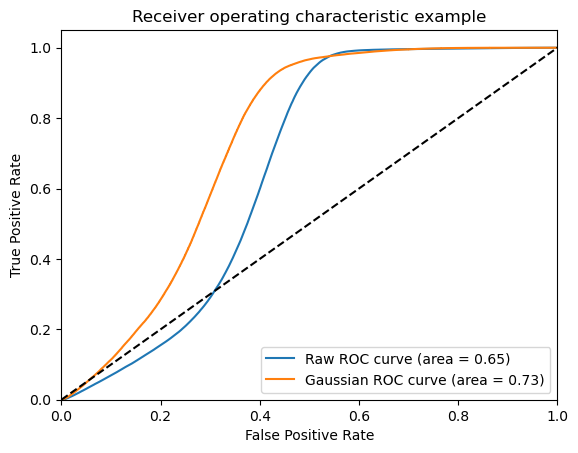

In [62]:
ground_truth_labels = lung_mask.ravel() # we want to make them into vectors
score_value = gus_image.ravel() # we want to make them into vectors
fpr_gus, tpr_gus, _ = roc_curve(ground_truth_labels,score_value)
roc_auc_gus = auc(fpr_gus,tpr_gus)

# Visualization
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fpr_gus, tpr_gus, label='Gaussian ROC curve (area = %0.2f)' % roc_auc_gus)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right");

# Tasks 

1. How can you improve filtering in this analysis?
    - Which filter elements might improve the area under the ROC?
    - WHy the results are not perfect?
2. Try making workflows to test out a few different filters
    - Where might morphological operations fit in?
    - How can you make them part of this workflow as well?
3. (Challenge) Try and use the optimize toolbox of scipy with the fmin
    function (from scipy.optimize import fmin) to find the optimum
    parameters for the highers area (hint: fmin finds the minimum value)

## Solution task 1
In this exercise we try to tune the width of the Gaussian filter kernel with the goal to obtain better segmentation performance. The ROC curve is used as our metric to evaluate the goodness of the applied filter. 

The task involves repeated use of the same operations. This is an ideal use case for writing a function to apply the filtering and visualize the results. The function is made up of a selection of the previous notebook cells. So, it all you need to do is 

In [67]:
def test_gaussians(img,gt,sigma,ax):
    gus_image = gaussian(img,sigma = sigma)
    threshold = 0.75
    thresholded = gus_image>threshold
    # Visualization
    ax[0].imshow(gus_image, cmap='gray')
    ax[0].set_title('Gaussian Filtered Image $\sigma$={0:0.2f}'.format(sigma))
    ax[1].imshow(thresholded, cmap = 'bone')
    ax[1].set_title(f'Test Segmentation with {threshold=}')
    
    ground_truth_labels = gt.ravel() # we want to make them into vectors
    score_value = gus_image.ravel() # we want to make them into vectors
    fpr_gus, tpr_gus, _ = roc_curve(ground_truth_labels,score_value)
    roc_auc_gus = auc(fpr_gus,tpr_gus)

    # Visualization
    ax[2].plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
    ax[2].plot(fpr_gus, tpr_gus, label='Gaussian ROC curve (area = %0.2f)' % roc_auc_gus)
    ax[2].plot([0, 1], [0, 1], 'k--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.05])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver operating characteristic example')
    ax[2].legend(loc="lower right");

Now, we'll use our function to test the effect of different filter widths. In this example we use $\sigma$={5,10,15,20,25}

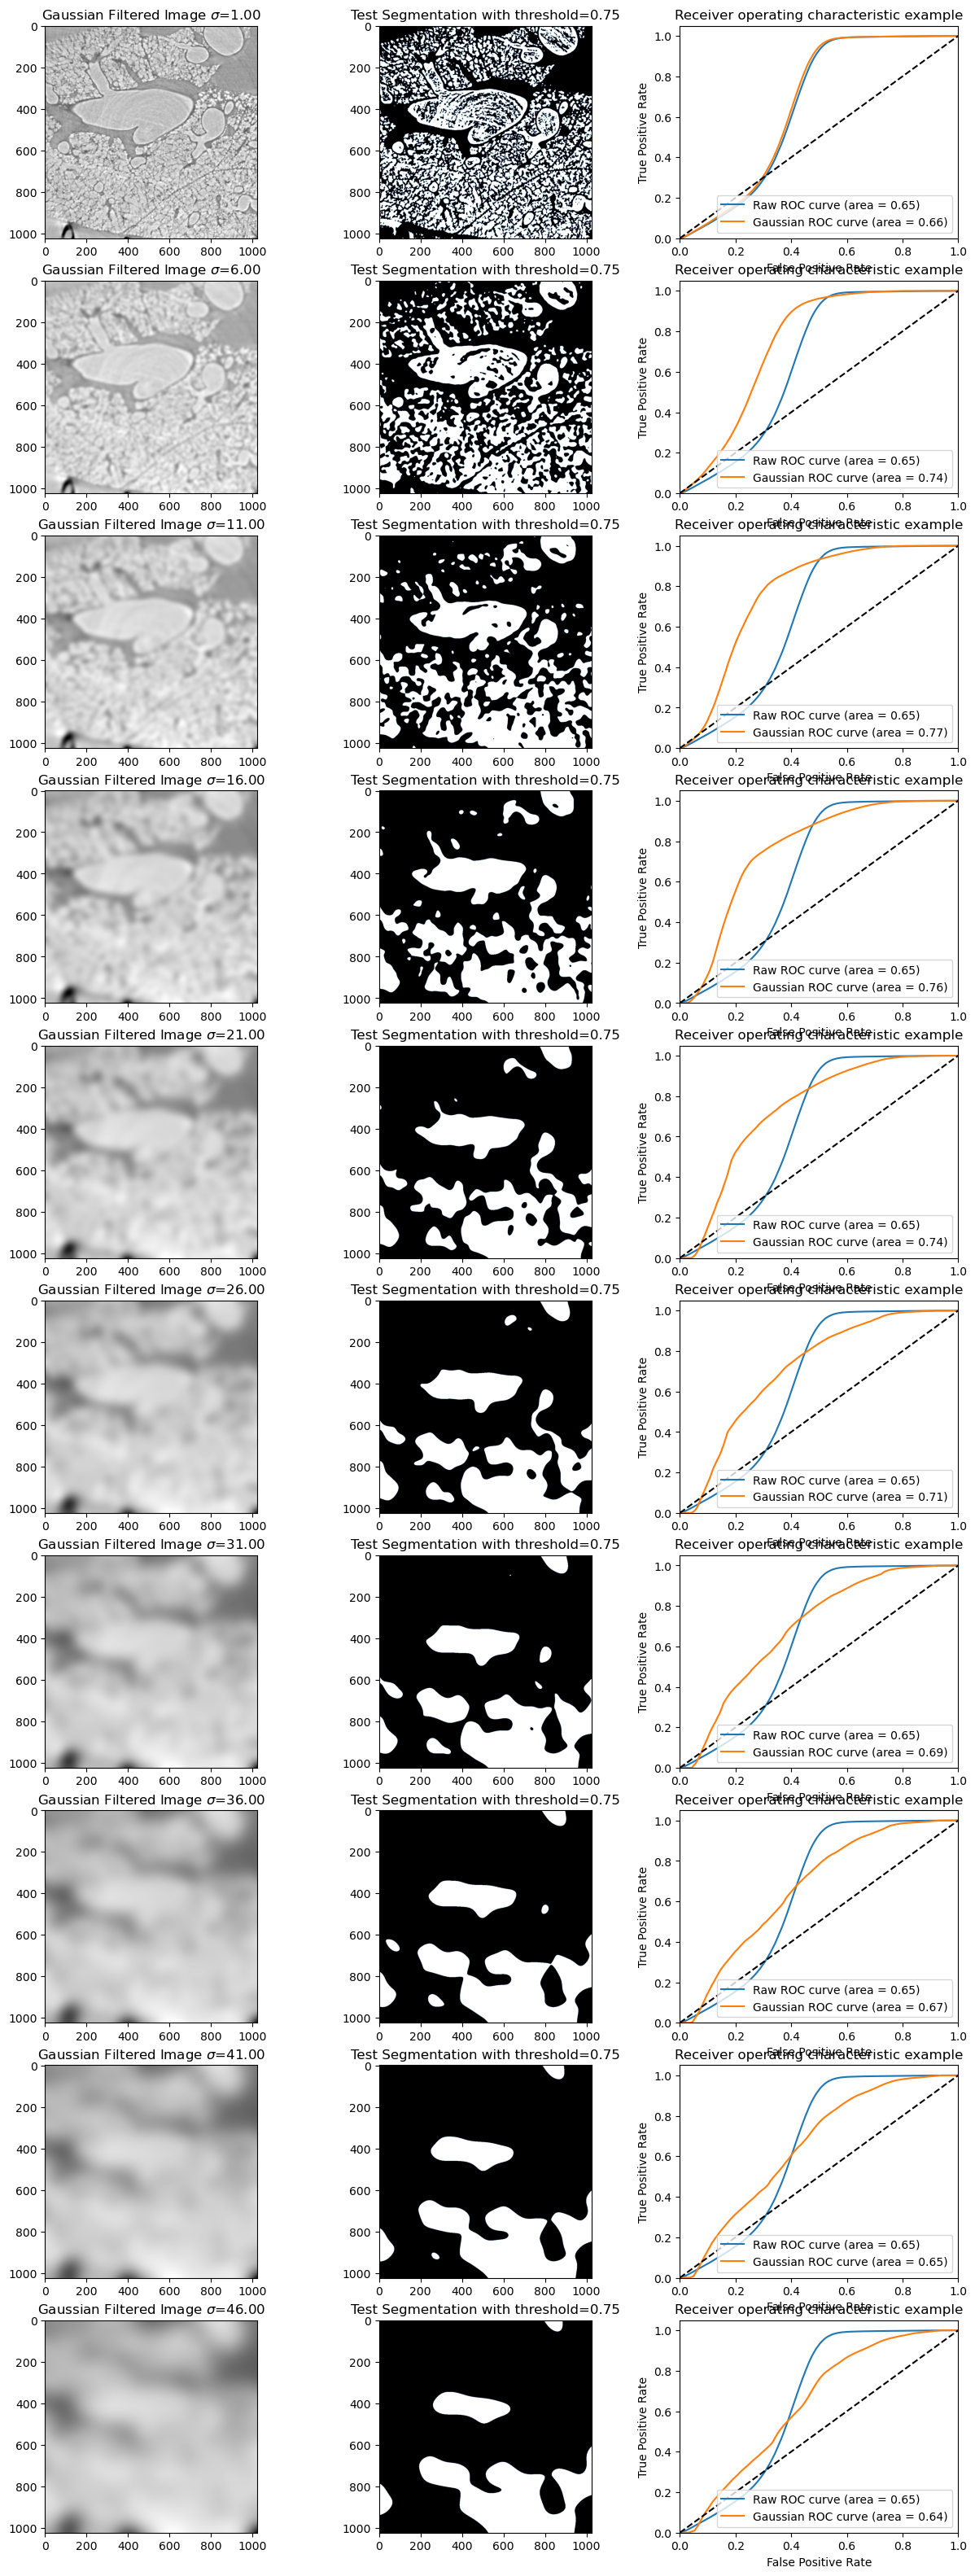

In [68]:
sigmas=range(1,50,5)
fig,axes=plt.subplots(len(sigmas),3,figsize=(15,4*len(sigmas)))
for s,ax in zip(sigmas,axes) :
    test_gaussians(lung_image,lung_mask,sigma=s,ax=ax)

### Conclusion
Applying a filter to smooth the image improves the AUC. It is important that the filter kernel is wider than the small features in the airways to blurr the shapes. At some point there is no gain in increasing the filter width, it only takes more time to process. 

The filter homogenizes the airways region but it does not emphazise the airways structure over other features in the image.

The results do not get perfect score due to the segmentation mask not containing the acini (smaller structures) that also have a similar pattern as the airways.